# Hypothesis Testing with Insurance Data

Import Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Load Data

In [24]:
url ="insurance - insurance.csv"

df = pd.read_csv(url,  low_memory=False)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Hypothesis

### Q1. Do smokers have higher insurance charges than non-smokers?

    Test type = 2 Sample T-Test
    
    - Null Hypothesis: Smokers and non-smokers have the same average insurance charges.
    - Alternative Hypothesis: Smokers have higher insurance charges than non-smokers.
    - Significance Level (Alpha): For this test, the alpha value is 0.05. 

    Assumptions:
    - No significant outliers
    - Normality
    - Equal Variance

In [26]:
# see how many smokers vs non-smokers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [27]:
# Filtering out smokers from non-smokers
non_smokers_df = df.loc[df['smoker']== 'no'].copy()
smokers_df = df.loc[df['smoker']== 'yes'].copy()

In [28]:
#Define feature of interest
non_smoker_charges = non_smokers_df['charges']
smoker_charges = smokers_df['charges']

#### Outliers

In [29]:
# Check for outliers in charges for non-smokers 
zscores= stats.zscore(non_smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [30]:
#loop to iteratively remove outliers until there are none left
outliers_exist = True
while outliers_exist:
    zscores = stats.zscore(non_smoker_charges)
    outliers = abs(zscores) > 3
    
    num_outliers = np.sum(outliers)
    
    if num_outliers > 0:
        non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]
    else:
        outliers_exist = False


In [31]:
zscores= stats.zscore(non_smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [32]:
# Check for outliers in charges for smokers 
zscores= stats.zscore(smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)

0

#### Normality

In [33]:
# test the non-smokers group for normality
result_non_smoker_charges = stats.normaltest(non_smoker_charges)
print(result_non_smoker_charges)

# Is the p-value less than 0.05?
result_non_smoker_charges.pvalue < .05

NormaltestResult(statistic=55.893468599675245, pvalue=7.292685861395211e-13)


True

In [34]:
result_smoker_charges = stats.normaltest(smoker_charges)
result_smoker_charges
print(result_smoker_charges)

# Is the p-value less than 0.05?
result_smoker_charges.pvalue < .05

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)


True

Both p-values are less than 0.05, meaning that we reject the null hypothesis. They deviate from a normal distribution, However, our sample size is large enough to proceed without satisfying this test.

#### Equal Variance

In [35]:
# Test for equal variance
result = stats.levene(non_smoker_charges, smoker_charges)
print(result)

# Is the p-value less than 0.05?
result.pvalue < .05


LeveneResult(statistic=791.4740947105306, pvalue=7.254211040409339e-136)


True

#### Perform and evaluate the t-test

In [36]:
result = stats.ttest_ind(non_smoker_charges, smoker_charges, equal_var = False)
print(result)

# Is the p-value less than 0.05?
result.pvalue < .05

Ttest_indResult(statistic=-34.76759075466699, pvalue=5.672680697343108e-106)


True

Our p-value is less than alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference between the charges of smokers and those of non-smokers.

### Q2. Are men more likely to smoke than women?

    Test Type: Chi-Square Test
    
    - Null Hypothesis: The proportion of smokers is the same for both genders
    - Alternative Hypothesis:: Men are more likely to smoke than women

    Assumptions:
    - There are two categorical variables (ordinal or nominal)
    - The outcomes are independent.

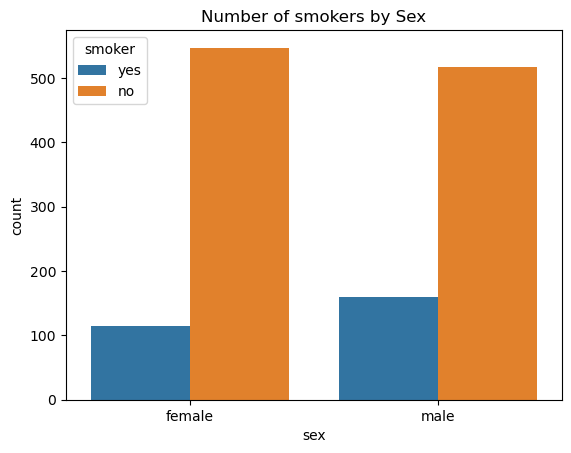

In [37]:
#Visualise smokers by sex
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of smokers by Sex");

In [38]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table



smoker,no,yes
sex,,
female,547,115
male,517,159


In [39]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [40]:
# prints p-value
print(p)
p<.05



0.006548143503580696


True

Our p-value is less than alpha (0.05), so we reject the null hypothesis the proportion of smokers is the same for both genders. 
This means that male are more likely to smoke than female

### Q3. Do different regions have different charges, on average?



    Test Type: ANOVA (Analysis of Variance)

    - Null Hypothesis: All regions have the same average charges
    - Alternative Hypothesis: The average insurance charges differ among regions

    Assumptions
    - No significant outliers
    - Equal variance
    - Normality
    

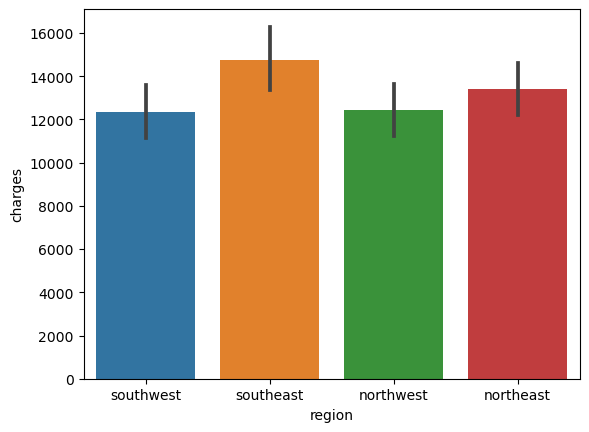

In [41]:
#Visualise the values
sns.barplot(data=df, x='region',y='charges');



In [42]:
## Create regions dictionary. 
region = {}
## Loop through all unique regions
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    region[i] = data
region.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

#### Assumption of Normality

In [43]:
## Running normal test on each region and confirming there are >20 in each region
norm_results = {}
for i, data in region.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T

### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


All regions have an alpha less than 0.05, therefore we reject the null hypothesis that they have normal distribution. Therefore, they do not have normal distributions. However, there are more than 20 samples in each region, therefore we can continue

#### Equal Variance

In [44]:
# with the * operator 
stats.levene(*region.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

This p-value indicates that there is strong evidence against the null hypothesis of equal variances across regions

#### One-Way ANOVA Test

In [45]:
# perform the correct hypothesis test
result = stats.f_oneway( *region.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

#### Tukey's Pairwise Multiple Comparisons Test

In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as kg_lost and the labels to the Diet
values = df['charges']
labels = df['region']

## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


There is only one significat result between southeast and southwest. Meaning that there is a difference in average insurance charges between southeast and southwest. However, there are no differnces in average insurance charges between all the other regions. 